## Runing the Linear AA on the MNIST dataset
- For the Benoulli method it requires adaptation, since the original MNIST isn't binarized, and this implementation was created for binary data.
- Binarizing your MNIST data is a straightforward process involving setting a threshold.Standard MNIST Data: A pixel $x_{i,j} \in \{0, 1, 2, \dots, 255\}$.Binarization Step: You apply a threshold, $T$, to every pixel in the dataset. A common practice for MNIST is to set $T=127.5$ (or 128) since the values range up to 255.The resulting binary pixel $x'_{i,j}$ would be calculated as:$$x'_{i,j} = \begin{cases} 1 & \text{if } x_{i,j} > T \\ 0 & \text{if } x_{i,j} \le T \end{cases}$$


In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt 
from src.methods.AALS import AALS 

In [2]:

# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
# Download MNIST
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# pick single digit
digit = 4
idx_digit = mnist_data.targets.numpy() == digit
data_digit = mnist_data.data[idx_digit,]
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))
print(data_digit.shape)

# Use all samples
n_samples = len(data_digit)
X_raw = torch.tensor(data_digit).float()
X = X_raw.flatten(start_dim=1).T 

X = X.double() 

print(f"Data Ready: {X.shape} (Features x Samples)")

Loading MNIST...
torch.Size([5842, 784])
Data Ready: torch.Size([784, 5842]) (Features x Samples)


/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_90184/2764844498.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw = torch.tensor(data_digit).float()


---

### Guassian Method

In [ ]:
n_runs = 10
n_archetypes = 3

S_list = []
C_list = []
L_list = []  # <-- store the losses

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    C_run, S_run, L_run, _ = AALS(X, n_archetypes)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)  # <-- add this line

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, 'mnist_gaussian_aa_results.pth')


Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


Final Archetype Matrix shape for plotting: (784, 3)


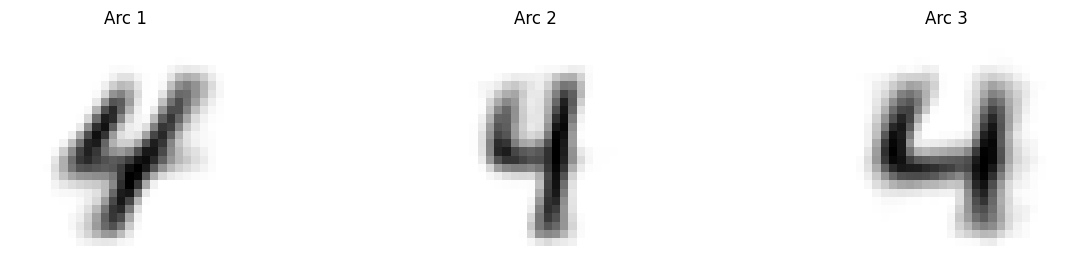

In [8]:
# --- REVISED VISUALIZATION BLOCK (The Definitive Fix) ---
import torch

# Choose a run to visualize
run_to_plot = 0
C_ = C_list[run_to_plot]
X = X  # Ensure X is available in this scope

# Assuming the variables C and X are available from the analysis run
# C is the first output from the analysis, which we now assume is the convex hull coefficient matrix (A)

# Ensure C and X are on the CPU and detached for calculation
if isinstance(C_, torch.Tensor):
    A_matrix = C_.detach().cpu() 
else:
    A_matrix = torch.from_numpy(C_)

if isinstance(X, torch.Tensor):
    X_data = X.detach().cpu()
else:
    X_data = torch.from_numpy(X)

# 1. Calculate the true Archetype Matrix (C = X @ A)
# C_plot shape will be (784, 2000) @ (2000, 10) = (784, 10)
C_plot = X_data @ A_matrix 

# 2. Convert to NumPy for plotting
C_np = C_plot.numpy()
n_archetypes = C_np.shape[1]

print(f"Final Archetype Matrix shape for plotting: {C_np.shape}") # Should be (784, 10)

# 3. Plotting Loop
fig, axes = plt.subplots(1, n_archetypes, figsize=(15, 3))
for i in range(n_archetypes):
    # This now uses the calculated (784, 10) matrix
    digit = C_np[:, i].reshape(28, 28)
    
    axes[i].imshow(digit, cmap='gray_r')
    axes[i].axis('off')
    axes[i].set_title(f'Arc {i+1}')

plt.show()

In [9]:
import torch
from torchvision import datasets, transforms
import numpy as np

# --- Corrected Data Loading ---
# The A matrix in the saved file has 5842 rows, so we must load 5842 samples.
N_SAMPLES_REQUIRED = 5842 

print(f"Reloading MNIST data with {N_SAMPLES_REQUIRED} samples...")
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Load the required number of samples
X_raw = mnist_data.data[:N_SAMPLES_REQUIRED].float() / 255.0 

# Reshape to (Features x Samples): (784, 5842)
X_data_tensor = X_raw.flatten(start_dim=1).t().double() # Ensure double type

print(f"Data re-loaded. Shape: {X_data_tensor.shape}")

# --- Simplified get_linear_matrices Function ---
# (Removing the confusing 'else' fallback that caused the ValueError)

def get_linear_matrices(pth_path, data_tensor):
    """
    Extracts S, C, and X from Linear AA results file.
    data_tensor: The original PyTorch tensor used for training (Features x Samples)
    """
    checkpoint = torch.load(pth_path)
    
    # 1. Extract Coefficients (S)
    S_linear = checkpoint['S']
    if isinstance(S_linear, torch.Tensor):
        S_linear = S_linear.detach().cpu().numpy()
        
    # 2. Prepare Data (X) and Convex Weights (A)
    A_matrix = checkpoint['C'] 
    X_in = data_tensor # (Features, Samples)
    
    if isinstance(A_matrix, torch.Tensor):
        A_matrix = A_matrix.detach().cpu().numpy()
    if isinstance(X_in, torch.Tensor):
        X_in = X_in.detach().cpu().numpy()
        
    # 3. Compute Archetypes (C = X @ A)
    # C_linear = (Features, Samples) @ (Samples, Archetypes) = (Features, Archetypes)
    C_linear = X_in @ A_matrix
    
    # 4. Prepare X (Samples, Features) for mSST
    X_linear_out = X_in.T
        
    return S_linear, C_linear, X_linear_out

# Now run your extraction function
S2, C2, X2 = get_linear_matrices('mnist_gaussian_aa_results.pth', X_data_tensor)

print("Extraction complete!")
print(f"S2 (Coefficients) shape: {S2.shape}")
print(f"C2 (Archetypes) shape: {C2.shape}")

Reloading MNIST data with 5842 samples...
Data re-loaded. Shape: torch.Size([784, 5842])


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy.core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.